# 프로젝트 : 모든 장르 간 편향성 측정해 보기
===========================================================================================

## 목차

>### 1. 데이터 토큰화
>### 2. Word2Vec 모델 만들기
>### 3. Coo matrix 만들기
>### 4. WEAT score 계산하기
>### 5. 회고
>### 6. Reference
>### 7. 자기다짐 및 아쉬운 점
---

## 루브릭 평가 기준

1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.
    - 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.
2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.
    - 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.
    - 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.
    
---    

## 1. 데이터 토큰화

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt
from gensim.models import Word2Vec
from numpy import dot
from numpy.linalg import norm
from tqdm import tqdm
import time

np.random.seed(42)

In [2]:
file_path = './data/synopsis/'
file_list = os.listdir(file_path)
file24_list = []
file21_list = []

for file in file_list:
    if file.endswith('.txt'):
        file24_list.append(file)
        
for i in range((len(file_list))):
    if 'synopsis_gen.txt' == file_list[i]:
        continue
    elif 'synopsis_art.txt' == file_list[i]:
        continue
    elif 'synopsis.txt' == file_list[i]:
        continue
    elif '.ipynb_checkpoints' == file_list[i]:
        continue    
    else:
        file21_list.append(file_list[i])

In [3]:
def tokenize(file_path, txt_list):
    okt = Okt()
    x = []
    start_time = time.time()
    for index, file_name in enumerate(txt_list):
        with open(file_path + file_name, 'r') as f:
            while True:
                line = f.readline()
                if not line:
                    break
                words = okt.pos(line, stem=True, norm=True)    
                word = []
                for w in words:
                    if w[1] == 'Noun':
                        word.append(w[0])
                x.append(word)
        print(f'{index+1} / {len(txt_list)} {file_name} 토큰화 종료')
        if index == 9 or index == 19:
            mid_time = time.time()
            x_time = int((mid_time - start_time)//60)
            print(f'현재까지 걸린 시간 {x_time} 분')
    end_time = time.time()
    fin_time = int((end_time - start_time) // 60)
    print(f'걸린 시간: {fin_time}분')
    print(f'전체 토큰 갯수 : {len(x)}')
    print('전체 토큰화 종료', '\n', '===='*26)
    
    return x

In [4]:
tokenizer = tokenize(file_path, file24_list)

1 / 24 synopsis_war.txt 토큰화 종료
2 / 24 synopsis_historical.txt 토큰화 종료
3 / 24 synopsis_musical.txt 토큰화 종료
4 / 24 synopsis_action.txt 토큰화 종료
5 / 24 synopsis_comedy.txt 토큰화 종료
6 / 24 synopsis_animation.txt 토큰화 종료
7 / 24 synopsis.txt 토큰화 종료
8 / 24 synopsis_drama.txt 토큰화 종료
9 / 24 synopsis_adventure.txt 토큰화 종료
10 / 24 synopsis_fantasy.txt 토큰화 종료
현재까지 걸린 시간 14 분
11 / 24 synopsis_art.txt 토큰화 종료
12 / 24 synopsis_crime.txt 토큰화 종료
13 / 24 synopsis_family.txt 토큰화 종료
14 / 24 synopsis_gen.txt 토큰화 종료
15 / 24 synopsis_romance.txt 토큰화 종료
16 / 24 synopsis_documentary.txt 토큰화 종료
17 / 24 synopsis_etc.txt 토큰화 종료
18 / 24 synopsis_thriller.txt 토큰화 종료
19 / 24 synopsis_horror.txt 토큰화 종료
20 / 24 synopsis_western.txt 토큰화 종료
현재까지 걸린 시간 28 분
21 / 24 synopsis_adult.txt 토큰화 종료
22 / 24 synopsis_SF.txt 토큰화 종료
23 / 24 synopsis_mystery.txt 토큰화 종료
24 / 24 synopsis_show.txt 토큰화 종료
걸린 시간: 28분
전체 토큰 갯수 : 202563
전체 토큰화 종료 


---
## 2. Word2Vec 모델 만들기

In [5]:
# w2v 만들기
w2v_model = Word2Vec(tokenizer, vector_size=100, window=5, min_count=3, sg=0)  

In [6]:
def similar_sentence(name):
    x = w2v_model.wv.most_similar(positive=[name])
    
    return x

In [7]:
similar_sentence('전쟁')

[('무니', 0.6445735096931458),
 ('전투', 0.609101414680481),
 ('참전', 0.6001994609832764),
 ('내전', 0.5928593873977661),
 ('참상', 0.5640655755996704),
 ('학살', 0.5554060935974121),
 ('조국', 0.5437023639678955),
 ('이라크', 0.5348640084266663),
 ('침공', 0.5345585346221924),
 ('혁명', 0.5264950394630432)]

In [8]:
similar_sentence('사랑')

[('행복', 0.5506606101989746),
 ('진심', 0.5260869264602661),
 ('연인', 0.5226418375968933),
 ('애정', 0.5075175166130066),
 ('삼각관계', 0.5012677907943726),
 ('키스', 0.5007421970367432),
 ('욕망', 0.4998745918273926),
 ('감정', 0.49736228585243225),
 ('가슴', 0.4942658543586731),
 ('진정', 0.49279457330703735)]

In [10]:
similar_sentence('가족')

[('부모님', 0.4693971872329712),
 ('부모', 0.447460412979126),
 ('할머니', 0.4281809329986572),
 ('가정', 0.42089807987213135),
 ('식구', 0.41382619738578796),
 ('어머니', 0.38994544744491577),
 ('비극', 0.3838944435119629),
 ('구성원', 0.37149420380592346),
 ('뿔뿔이', 0.37122952938079834),
 ('가정폭력', 0.37021806836128235)]

In [11]:
similar_sentence('총')

[('겨누', 0.7539818286895752),
 ('겨눈', 0.6755596995353699),
 ('인질', 0.672991931438446),
 ('칼', 0.64452064037323),
 ('총구', 0.6286461353302002),
 ('권총', 0.6274006366729736),
 ('아군', 0.6157263517379761),
 ('방아쇠', 0.6155591607093811),
 ('살인마', 0.5996993780136108),
 ('총알', 0.5935567021369934)]

In [12]:
similar_sentence('비행기')

[('열차', 0.7791846990585327),
 ('탑승', 0.7506200671195984),
 ('보트', 0.7323253750801086),
 ('추락', 0.7148520946502686),
 ('기차', 0.7146342396736145),
 ('차량', 0.6983028650283813),
 ('승객', 0.692213237285614),
 ('터널', 0.6870747804641724),
 ('트럭', 0.6810439825057983),
 ('공항', 0.6797153353691101)]

---
## 3. Coo matrix 만들기

In [13]:
art_text = 'synopsis_art.txt'
gen_text = 'synopsis_gen.txt'

def read_token(file_path, txt):
    okt = Okt()
    result = []
    start_time = time.time()
    with open(file_path + txt, 'r') as f: 
        while True:
            line = f.readline() 
            if not line: 
                break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append((word[0]))                     
    end_time = time.time()
    print(f'걸린 시간 {int((end_time-start_time)//60)} 분')
    print(f'{txt} 토큰화 종료')
    print('===='*26)
    return ' '.join(result)

In [14]:
art = read_token(file_path, art_text)
gen = read_token(file_path, gen_text)

걸린 시간 1.0 분
synopsis_art.txt 토큰화 종료
걸린 시간 9.0 분
synopsis_gen.txt 토큰화 종료


In [15]:
print('예술영화 데이터 길이: ', len(art))
print('일반영화 데이터 길이: ', len(gen))

예술영화 데이터 길이:  620208
일반영화 데이터 길이:  3014815


In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen]) #CSF-matrix로 변환

print(X.shape)

(2, 41082)


In [17]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. csr -> coo matrix형태로 변경
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. csr -> coo matrix형태로 변경

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

n = 25
w1_, w2_ = [], []

for i in range(1000):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]]) #tfidf 모듈 내에 가지고있는 feature name을 호출
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(1000):
    if (w1_[i] not in w2_) and (w1_[i] in w2v_model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(1000):
    if (w2_[i] not in w1_) and (w2_[i] in w2v_model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break
        
print(f'예술영화 대표 단어 {n}개 ','\n', target_art)
print(f'일반영화 대표 단어 {n}개 ','\n', target_gen)

예술영화 대표 단어 25개  
 ['북한', '황제', '레오', '아담', '진심', '무작정', '줄리', '뮤지션', '피아노', '외면', '선언', '메리', '카페', '단편영화', '뜻밖', '폭탄', '로마', '다니엘', '가면', '영화감독', '요괴', '실화', '수현', '한나', '알리']
일반영화 대표 단어 25개  
 ['페스티벌', '다큐', '이미지', '정사', '아시아나', '인디애니페스트', '마사지', '비디오', '불륜', '최강', '에피소드', '개발', '상영', '애니', '출장', '만화', '남성', '유부녀', '현대', '악몽', '희생', '아시아', '기술', '포럼', '필름']


In [18]:
genre_name = ['전쟁', '역사', '뮤지컬', '액션', '코메디', '애니메이션', '드라마', '어드벤처',
 '판타지', '범죄', '가족', '로맨스', '다큐멘터리', '기타', '스릴러', '호러', '웨스턴',
 '성인', 'SF', '미스터리', '공연']

genre = []
count = 1
for file_name in file21_list:
    print(f'{count}/{len(file21_list)} 토큰화 중')
    genre.append(read_token(file_path, file_name))
    count += 1
print('전체 토큰화 종료', '\n', '===='*26)          

1/21 토큰화 중
걸린 시간 0.0 분
synopsis_war.txt 토큰화 종료
2/21 토큰화 중
걸린 시간 0.0 분
synopsis_historical.txt 토큰화 종료
3/21 토큰화 중
걸린 시간 0.0 분
synopsis_musical.txt 토큰화 종료
4/21 토큰화 중
걸린 시간 1.0 분
synopsis_action.txt 토큰화 종료
5/21 토큰화 중
걸린 시간 0.0 분
synopsis_comedy.txt 토큰화 종료
6/21 토큰화 중
걸린 시간 1.0 분
synopsis_animation.txt 토큰화 종료
7/21 토큰화 중
걸린 시간 3.0 분
synopsis_drama.txt 토큰화 종료
8/21 토큰화 중
걸린 시간 0.0 분
synopsis_adventure.txt 토큰화 종료
9/21 토큰화 중
걸린 시간 0.0 분
synopsis_fantasy.txt 토큰화 종료
10/21 토큰화 중
걸린 시간 0.0 분
synopsis_crime.txt 토큰화 종료
11/21 토큰화 중
걸린 시간 0.0 분
synopsis_family.txt 토큰화 종료
12/21 토큰화 중
걸린 시간 0.0 분
synopsis_romance.txt 토큰화 종료
13/21 토큰화 중
걸린 시간 1.0 분
synopsis_documentary.txt 토큰화 종료
14/21 토큰화 중
걸린 시간 0.0 분
synopsis_etc.txt 토큰화 종료
15/21 토큰화 중
걸린 시간 0.0 분
synopsis_thriller.txt 토큰화 종료
16/21 토큰화 중
걸린 시간 0.0 분
synopsis_horror.txt 토큰화 종료
17/21 토큰화 중
걸린 시간 0.0 분
synopsis_western.txt 토큰화 종료
18/21 토큰화 중
걸린 시간 0.0 분
synopsis_adult.txt 토큰화 종료
19/21 토큰화 중
걸린 시간 0.0 분
synopsis_SF.txt 토큰화 종료
20/21 토큰화 중
걸린 시간 0.0 분
synopsis

In [19]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [20]:
m = [X[i].tocoo() for i in range(X.shape[0])] # 21개의 coo matrix를 m에 할당함.

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m] # 21개의 행렬을 하나씩 뽑아서 추출

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True) # 21개의 행렬이기에 range 이용
    
attributes = []
for i in range(len(w)): # len(w) == 21
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < n):
        if vectorizer.get_feature_names()[w[i][j][0]] in w2v_model.wv: # w[몇번째인지][무슨값인지][그중 어느것인지]
                                                                       # w[행렬][0] = [26253, 0.29293932]
                                                                       # w[행렬][0][0] = [26253]
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print('\n', '----'*26)

전쟁: 전쟁, 독일군, 전투, 위해, 작전, 시작, 부대, 윈터스, 독일, 연합군, 미군, 임무, 자신, 사람, 나치, 병사, 공격, 이지중대, 혁리, 대원, 중위, 세계대전, 군인, 동막골, 대위, 
 --------------------------------------------------------------------------------------------------------
역사: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 운명, 최고, 사람, 하선, 전쟁, 윤서, 트로이, 세자, 허균, 노준, 채선, 신재효, 히파티아, 권력, 아킬레스, 
 --------------------------------------------------------------------------------------------------------
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 프롤, 모도, 카르피, 시작, 제루샤, 샤오캉, 위해, 데이비, 팬텀, 최고, 
 --------------------------------------------------------------------------------------------------------
액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 모든, 목숨, 사실, 친구, 가족, 요원, 임무, 범죄, 세계, 살인, 한편, 아버지, 복수, 죽음, 아들, 마약, 
 --------------------------------------------------------------------------------------------------------
코메디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 이야기, 인생, 아이, 아버지, 마음, 모든, 생각, 결혼, 엄마, 서로, 
 -------------

---
## 4. WEAT score 계산하기

In [21]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B): # weat 전체 수식
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [22]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([w2v_model.wv[word] for word in target_art])
Y = np.array([w2v_model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([w2v_model.wv[word] for word in attributes[i]])
        B = np.array([w2v_model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [23]:
for i in range(len(genre_name)-1):
    print('----'*26)
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

--------------------------------------------------------------------------------------------------------
전쟁 역사 -0.11401509
전쟁 뮤지컬 0.27531692
전쟁 액션 -0.28538087
전쟁 코메디 -0.10020702
전쟁 애니메이션 0.4913138
전쟁 드라마 0.090660974
전쟁 어드벤처 -0.118768856
전쟁 판타지 0.1600542
전쟁 범죄 -0.082069844
전쟁 가족 -0.19528884
전쟁 로맨스 -0.05738832
전쟁 다큐멘터리 0.5021489
전쟁 기타 0.4471005
전쟁 스릴러 -0.20923586
전쟁 호러 -0.11090294
전쟁 웨스턴 -0.47607112
전쟁 성인 0.18677802
전쟁 SF 0.046366554
전쟁 미스터리 -0.121173225
전쟁 공연 -0.11159328
--------------------------------------------------------------------------------------------------------
역사 뮤지컬 0.63762325
역사 액션 -0.37528393
역사 코메디 -0.06977135
역사 애니메이션 0.8282578
역사 드라마 0.30501518
역사 어드벤처 -0.08227695
역사 판타지 0.5759393
역사 범죄 0.002578475
역사 가족 -0.26263645
역사 로맨스 -0.0049813776
역사 다큐멘터리 0.8205571
역사 기타 0.8326035
역사 스릴러 -0.24976678
역사 호러 -0.07022082
역사 웨스턴 -0.8939978
역사 성인 0.37746036
역사 SF 0.25794408
역사 미스터리 -0.09407022
역사 공연 -0.06388835
------------------------------------------------------------------------

<AxesSubplot:>

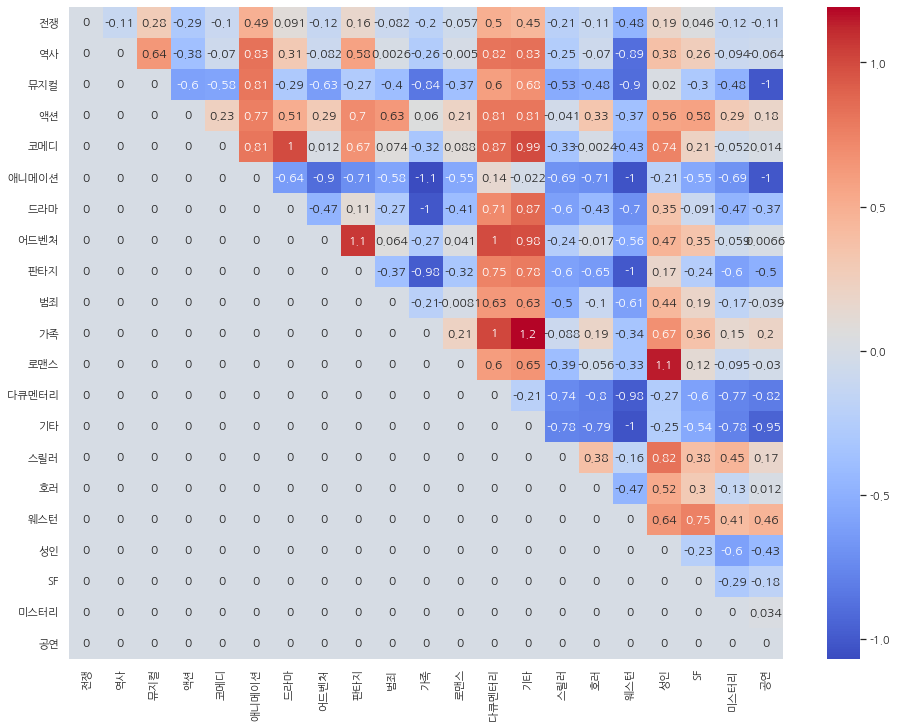

In [24]:
# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.figure(figsize=(16,12))
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='coolwarm')
ax

---
## 5. 회고

### 이번 프로젝트를 하면서 어려웠던 점
>- 솔직히 이번 프로젝트는 데이터셋의 문제인지? 편향을 파악하고자 하는 주제인데 예술영화인지 상업영화인지 그것이 중요한가.. 그런 의문이 상당히 많이 들었습니다. LMS 첫 예시인 곤충 == 불쾌, 꽃 == 유쾌 와 같은 더 직관적인것도 좋고 직업에 대한 남성 편향적인지 여성편향적인지 체크하는 예시도 다 좋았는데 갑자기 프로젝트에 들어서 너무 뜬금없는 얘기가 나오니 하고도 제대로 잘 된것인지 모호했습니다. 그래도 처음보는 함수들도 많이 나왔고 오랜만에 CSR_matrix나 COO_matrix가 나와서 그 논리 이해가 조금 어려웠습니다.

### 이번 프로젝트에서 학습한 내용
>- 이번 프로젝트에선 CSR_matrix와 COO_matrix, 그리고 리스트 표현식에 대해 더 공부하게 되었습니다. 또한 Word2Vec에 대한 개념이 확실하게 잡혔으며 앞으로 훨씬 수월하게 사용할 수 있을듯 합니다.

### 알아낸 점이나 모호한 점
>- CSR_matrix와 COO_matrix의 차이를 알게되었고 각 행 열 데이터값을 구하는법과 그 데이터를 이용하는 법에 대해 배웠습니다. 하지만 아직도 모호하며 예전 추천시스템에서 썼던 방식과는 조금 달라 조금 더 사용해보며 체득해야 할듯 합니다.

### 루브릭 평가지표를 맞추기 위해 노력했던 점
>- __1. 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.__ 에 대해서는 위에서 '전쟁', '사랑', '가족', '총', '비행기' 라는 단어로 시도해보았으며 중간중간 어긋난 값들이 있긴 하지만 대체적으로 상당히 유사한 값을 보여주는 것을 알 수 있습니다.
>
>    
>- __2. 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.__ 위에서 서술하였듯 중복을 제거하였으며 각 장르를 대표하는 25개의 단어를 추출하였습니다.
>    
>        
>- __3. 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.__ 제 생각과 유사하게 WEAT score가 나왔으며 이를 heatmap으로 표현하였습니다. 하지만 중간중간 이해되지않는 WEAT score도 종종 있었습니다.

### 루브릭 평가지표를 달성하지 못했다면 이유
>- 2,3번 루브릭에서 달성하지 못했을것 같기도한데 특히나 3번에서 WEAT score가 제 생각과는 다른 수치로 튀는 몇몇 장르들이 있었고 이에 대한 것이 데이터의 전처리 문제였나.. 싶습니다.

---
## 6. Reference

- [os 모듈 참고 블로그](https://boleumdal.tistory.com/entry/python-%ED%8F%B4%EB%8D%94-%EC%95%88%EC%97%90-%EC%9E%88%EB%8A%94-%ED%8C%8C%EC%9D%BC-%ED%95%9C%EB%B2%88%EC%97%90-%EB%B6%88%EB%9F%AC%EC%98%A4%EA%B8%B0)
- [sparse matrix 참고 블로그](https://library-of-k.tistory.com/18)
- [coo matrix 참고 블로그](https://radish-greens.tistory.com/1)
- [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)

---
## 7. 자기다짐 및 아쉬운 점

- 이번 프로젝트는 상당히 아쉽습니다. 뭔가 후에도 크게 사용하지 않을것같은 내용이기도 했으며 상당히 관심을 갖고 있던 Embedding 파트였는데 정작 Embedding이 무엇인가에 대해서는 제대로 배우지 못한듯 합니다.
    
    
- 다만, Word2Vec에 대해선 확실히 배우게 되었으며 이는 상당히 좋은 부분이었다고 생각합니다. 
    
    
- 이제 다음 노드로 나오는것이 seq2seq와 어텐션인데 매우 기대가 됩니다.